## Assignment 3 Question 2

Is it possible to predict ELO of a player based on context of a potential en passant move?

Only investigating the player who is in the position of making the en passant move.

Lila See FDS PCA solutions for 3 good points for what PCA is good for - include in report?

#### Import Libraries

In [5]:
import pandas as pd
import chess
import chess.pgn
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import time

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### Import CSV file

66879 entries in dataframe

In [6]:
# Load CSV into a big dataframe
CHESS_DATA_LOCATION = "data/club_games_data.csv"
chess_data = pd.read_csv(CHESS_DATA_LOCATION)

#### Dataframe info

Using:
print(chess_data.dtypes)
print(chess["rules"].unique())


Chess rules:
['chess' 'chess960' 'threecheck' 'crazyhouse' 'kingofthehill']

Time control:
['1/259200' '1/172800' '1800' '1/86400' '1/432000' '1/604800' '600'
 '120+1' '900+10' '300' '180+2' '3600+5' '2700+45' '3600' '1/1209600'
 '180' '600+10' '60' '480+3' '300+5' '420+3' '600+5' '600+2' '1200' '30'
 '60+1' '120' '1500+3' '900+2' '1500+5' '1500+10' '1/864000' '900' '300+2'
 '1500' '7200' '300+1' '5400' '3600+60' '2700+30' '3480+45' '10' '2700+10'
 '15' '2700' '3600+20' '4500' '4200' '900+5' '1800+10' '2700+5' '480+5'
 '1800+30' '300+3' '600+1' '1800+5' '420+5' '5400+30' '240+10' '420' '303'
 '60+10']

 Time class:
['daily' 'rapid' 'bullet' 'blitz']

#### Clean data

Undeveloped board shouldn't matter if we're filtering games for potential ep

Same for draws

Can filter our time class if are looking at time controls

After making a new move_list column, should we drop the pgn column?


Variables we are considering when predicting ELO (for a player who could potentially make en passant move) are: (Y = DONE, N = NOT DONE)
- Y: Colour who had ep opportunity (boolean)
- Y: Did they take the en passant? (boolean)
- N: Does their choice on taking/not taking support them if gaining an advantage? (numerical value for how much of an advantage it gives)
- N: Time taken to decide to capture/not capture en passant (... whatever can be time, a number in seconds ig)
- Y: Is the game rated? (boolean)
- Y: Game time class


To do:
- Work out which colour is making the potential en passant move, add a column to dataframe detailing this
- Make dataframe columns for other variables
- Apply PCA reduction

In [7]:
# Drops rows if any value is a NaN (data is clean so it doesn't do anything)
chess_data.dropna(axis=0, how='any')

# Filter out alternative rules like chess960 etc
# Important this comes before the drop irrelevant columns line
chess_data = chess_data[chess_data['rules'] == "chess"]

# Save PGN column from dataframe
full_pgn = chess_data['pgn']

def get_moves(entry):
    '''
    Retrive series of moves in a game when given the whole full_pgn entry
    '''
    pgn = entry.splitlines()[-1]
    return pgn

# Add list of moves (string) as a new column to dataframe
chess_data['move_list'] = full_pgn.apply(get_moves)

# Drop irrelevant columns
chess_data = chess_data.drop(['time_control', 'white_username', 'black_username','white_id', 'black_id', 'white_result', 'black_result', 'rules'], axis=1)




#### Import chess info
https://python-chess.readthedocs.io/en/latest/core.html#chess.Board.san


#### En Passant functions
- has_legal_en_passant() tests if en passant capturing would actually be possible on the next move.
- has_pseudo_legal_en_passant()
- has_legal_en_passant()
- is_en_passant(move: Move) Checks if the given pseudo-legal move is an en passant capture.




Use StringIO to parse games from a string.

```python
import io
pgn = io.StringIO("1. e4 e5 2. Nf3 *")
game = chess.pgn.read_game(pgn)
```

#### Clean data specifically for ep

Filter out columns that don't have potential ep
Add columns for: whether ep happened, which colour had potential to take ep

In [32]:
def check_pgn_opportunity(pgn_in):
    '''
    Checks PGN for whether opportunity for EP happened in the game.
    '''
    pgn = io.StringIO(pgn_in.split()[-1])       # PGN as a file
    game = chess.pgn.read_game(pgn) # Read PGN and put into game
    board = game.board()            # "board" of a game
    
    precheck = False                # Is en passant possible

    # Find only pawn moves in game
    for move in game.mainline_moves():
        # B bishop Q queen K king N knight R rook O castle ELSE pawn
        san = board.san(move)
        move_piece = san[0]
        
        # lestring = "abcdefg"
        # if [e in lestring for e in [move_piece] if e in lestring]:
        # if move_piece.startswith(("a", "b", "c", "d", "e", "f", "g")):
        # if (re.search("^[abcdefg]", move_piece) != None):
        if move_piece in "abcdefg":
            # Push the move before checking the board
            board.push(move)
            precheck = board.has_legal_en_passant()

            # Return True the moment a potential ep move has been found
            if precheck:
                return True
        else:
            board.push(move)
            continue
                
    # If ran through every move without ep opportunity then return False
    return False

def check_pgn_happened(pgn_in):
    '''
    Checks PGN for whether EP actually happened in the game.

    Assumes game passed in already has the opportunity for an EP move.
    Returns True if EP was actually the next move.
    '''
    pgn = io.StringIO(pgn_in.split()[-1])       # PGN as a file
    game = chess.pgn.read_game(pgn) # Read PGN and put into game
    board = game.board()            # "board" of a game
    
    moved = False                   # Was en passant moved?

    # Find only pawn moves in game
    for move in game.mainline_moves():
        # B bishop Q queen K king N knight R rook O castle ELSE pawn
        san = board.san(move)
        move_piece = san[0:1]

        if (re.search("[abcdefg]x", move_piece) != None):
            moved = board.is_en_passant(move)
            # If ep actually happened, immediately return True
            if moved:
                return True
            board.push(move)
        else:
            board.push(move)
            continue
                
    # If ran through every move without ep then return False
    return False

def check_pgn_turn(pgn_in):
    '''
    Checks which player has the opportunity for EP.

    Assumes check_pgn_opportunity is true for this pgn - otherwise None is returned.
    Returns 'White' or 'Black' depending on which player has opportunity for ep
    '''
    pgn = io.StringIO(pgn_in.split()[-1])       # PGN as a file
    game = chess.pgn.read_game(pgn) # Read PGN and put into game
    board = game.board()            # "board" of a game
    
    precheck = False                # Is en passant possible

    # Find only pawn moves in game
    for move in game.mainline_moves():
        # B bishop Q queen K king N knight R rook O castle ELSE pawn
        turn = board.turn
        san = board.san(move)
        move_piece = san[0]

        if move_piece in "abcdefg":
            # Push the move before checking the board
            board.push(move)
            precheck = board.has_legal_en_passant()

            # Return True the moment a potential ep move has been found
            if precheck:
                if turn:
                    return 'Black'
                else:
                    return 'White'
        else:
            board.push(move)
            continue
    # If pgn without ep opportunity was passed in, return None
    return None


# Save PGN column from dataframe
full_pgn = chess_data['pgn']

print("first function")
start = time.time()
# Add Boolean value to dataframe for whether an ep opportunity arose
chess_data['ep_opportunity'] = full_pgn.apply(check_pgn_opportunity)
end = time.time()
print(end - start)


# Filter out games where ep didn't happen
chess_data = chess_data[chess_data['ep_opportunity'] == True]
chess_data = chess_data.drop(['ep_opportunity'], axis=1)

# Re-save PGN column from updated dataframe
full_pgn = chess_data['pgn']

print("second function")
start = time.time()
# Add Boolean value to dataframe for whether an ep capture actually happened
chess_data['ep_happened'] = full_pgn.apply(check_pgn_happened)
end = time.time()
print(end - start)

print("third function")
start = time.time()
# Add column indicating the colour of the player who had the ep choice
chess_data['ep_colour'] = full_pgn.apply(check_pgn_turn)
end = time.time()
print(end - start)

first function
0.31719112396240234


In [28]:
# first function
# 324.53476786613464
# second function
# 29.074277639389038
# 5366

# with regex:

# first function
# 25.838924646377563
# second function
# 32.171029806137085
# third function
# 24.009830713272095



# case switch
# 324.53476786613464

# regex
# 25.838924646377563

# startswith tuples
# 22.949651956558228

# startswith (no fen)
# 22.792099952697754

# string "in"
# 22.84489679336548

# list comprehension
# 22.962693452835083

print(len(chess_data))

5230


#### Cleaning data for EP - Advantage for ep

Analysing game - finding if ep move would have given an edvantage


Split into cases: ep happened and ep didn't happen


NOT DONE YET

In [ ]:
# def find_fen_ep_opportunity(pgn_in):
#     '''
#     Returns FEN of board when the ep opportunity arises
#     '''
#     pgn = io.StringIO(pgn_in)       # PGN as a file
#     game = chess.pgn.read_game(pgn) # Read PGN and put into game
#     board = game.board()            # "board" of a game
    
#     precheck = False                # Is en passant possible
#     moved = False                   # Did ep happen

#     fen_before_ep = ""
#     fen_after_ep = ""
#     reached_ep_opp = 0

#     # Find only pawn moves in game
#     for move in game.mainline_moves():
#         # B bishop Q queen K king N knight R rook O castle ELSE pawn
#         turn = board.turn
#         san = board.san(move)
#         move_piece = san[0]

#         match move_piece:
#             # Ignore if not pawn
#             case "K" | "Q" | "B" | "N" | "R" | "O":
#                 board.push(move)
#                 continue

#             # Pawn
#             case _:
#                 # Find the ep opportunity move
#                 # Push the move before checking the board
#                 moved = board.is_en_passant(move)
#                 board.push(move)
#                 precheck = board.has_legal_en_passant()

                
#                 if moved:
#                     fen_after_ep = board.fen()
#                     # Break out of loop
#                     return fen_before_ep, fen_after_ep
#                 elif reached_ep_opp > 0:
#                     # If ep wasn't taken, find fen for if it was actually taken

#                     # LILA STILL GOT TO DO THIS
#                     # (Find what the ep move would be and add it to the pgn if ep hadn't actually been chosen)
                    
#                 elif precheck:
#                     fen_before_ep = board.fen()
#                     reached_ep_opp += 1
                
#     # If pgn without ep opportunity was passed in, return None
#     return fen_before_ep, fen_after_ep





# def find_ep_advantage(pgn_in, ep_happened):
#     '''
#     Returns advantage given from ep move
#     '''
#     pgn = io.StringIO(pgn_in)       # PGN as a file
#     game = chess.pgn.read_game(pgn) # Read PGN and put into game
#     board = game.board()            # "board" of a game

#     fen_before_ep = find_fen_ep_opportunity(pgn)


### Number of games with at least 1 possible en-passant move - ???:
## 4750
(maybe 4913 or even 4945)

### Number of games with an actual en-passant move - ???:
## 1566

#### Applying PCA


In [ ]:
# Replace Boolean and string variables with numbers
chess_data['ep_happened'] = chess_data['ep_happened'].replace({True:1, False:0})
chess_data['ep_colour'] = chess_data['ep_colour'].replace({'White':1, 'Black':0})
chess_data['rated'] = chess_data['rated'].replace({True:1, False:0})
chess_data['time_class'] = chess_data['time_class'].replace({'daily':3, 'rapid':2, 'blitz':1, 'bullet':0})

# Drop irrelevant columns, and save differently - as a dataframe including the rating and one without
chess_data_with_elo = chess_data.drop(['fen', 'pgn', 'move_list'], axis=1)
chess_data_without_elo = chess_data_with_elo.drop(['white_rating', 'black_rating'], axis=1)

print(chess_data_with_elo.head())
print('\n')
print(chess_data_without_elo.head())

    white_rating  black_rating  time_class  rated  ep_happened  ep_colour
40          1569          1546           3      1            1          1
48          1505          1635           3      1            1          1
55          1468          1870           3      1            0          1
56          1530          1459           3      1            1          0
81          1498          1540           2      1            0          1


    time_class  rated  ep_happened  ep_colour
40           3      1            1          1
48           3      1            1          1
55           3      1            0          1
56           3      1            1          0
81           2      1            0          1


##### Data Standardisation (For PCA)

Cite week 8 lab sheet in report? Heavily used their code to help

Text(0, 0.5, 'PC2')

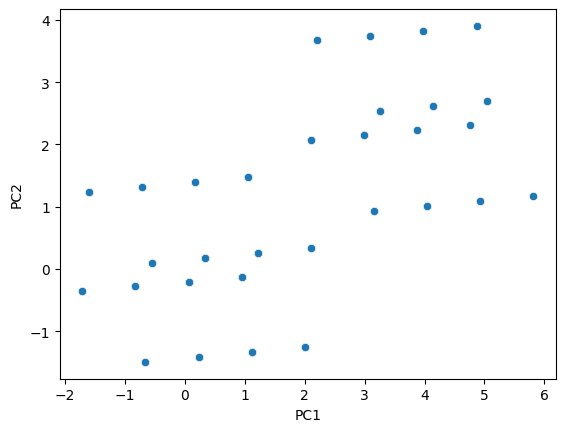

In [ ]:
# THIS PART IS COPIED AND PASTED FROM WEEK 8 PCA SOLUTIONS:
def sort_eigenvalues(eigenvalues, eigenvectors):
    idx = eigenvalues.argsort()[::-1]   
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:,idx]
    return eigenvalues, eigenvectors

# THE REST IS HEAVILY INFLUENCED BY WEEK 8 PCA SOLUTIONS

# Standardise chess_data_without_elo so that it follows the Standard normal distribution
for col in chess_data_without_elo.columns:
        chess_data_without_elo[col] = (chess_data_without_elo[col] - chess_data_without_elo[col].mean()) / chess_data_without_elo[col].std()

# # Create matrix storing covariances of the chess dataframe features
# covariances = np.cov(chess_data_without_elo.values.T)

# # Record eigenvalues and eigenvectors
# eigenvalues, eigenvectors = np.linalg.eig(covariances)
# eigenvalues, eigenvalues = sort_eigenvalues(eigenvalues, eigenvectors)

# result = chess_data_without_elo.dot(eigenvectors[:,:2])

# sns.scatterplot(x= result[0], y = result[1], hue=diagnosis)
# plt.xlabel('PC1')
# plt.ylabel('PC2')




# Lila Can we instead use this? :
pca = PCA(n_components=3).fit(chess_data_without_elo.values)
pca_result = pca.transform(chess_data_without_elo.values)
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')